In [2]:
# ADATA
import scanpy as sc

# NETWORK
import pandas as pd
import os

# MOTIFS

import numpy as np
from cytoolz import compose
import operator as op
import os
from os import listdir

from pyscenic.utils import load_motifs # Load motifs from step 2
from pyscenic.transform import df2regulons # Used in regulon creation in derive_regulon custom function

# AUCELL 
import json
import zlib
import base64
import loompy as lp
import pandas as pd

# ADATA EXPORT
from pyscenic.export import export2loom, add_scenic_metadata

/opt/venv/lib/python3.10/site-packages/loompy/view_manager.py:23: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if type(slice_) is not tuple or len(slice_) is not 2:


In [3]:
DATA_DIR = "/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/Integration/adata/adata_scanvi_predictions.h5ad"
MODULE_DIR = "/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/grn/01Networks/"
MOTIFS_DIR = "/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/grn/03Motifs/"
DB_DIR = "/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/grn/Common_files/databases"
AUCELL_DIR = "/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/grn/04AUCell/"

# ADATA 

In [4]:
adata_orig = sc.read_h5ad(DATA_DIR)
adata_orig.obs['cell_type'] = adata_orig.obs.GennAnno_ScAnvi

In [5]:
adatas = {}

In [6]:
for t_type in adata_orig.obs['subtype'].cat.categories:
    ad_tum = adata_orig[adata_orig.obs['subtype'] == t_type,:].copy()
    adatas[t_type] = ad_tum

In [7]:
adatas.keys()

dict_keys(['ER', 'HER2', 'TNBC'])

# MODULES

Gene modules are genes that show co-expression across cells in the dataset ( TF + gene). 

The strenght of that co-expression is measured by the column "importance"

In [8]:
modules = {}
for t_type in adata_orig.obs['subtype'].cat.categories:
    mod_dir = os.path.join(MODULE_DIR, f"{t_type}_network.tsv")
    mod_tum = pd.read_table(mod_dir, sep = "\t")
    modules[t_type] = mod_tum

In [9]:
for module in modules.values():
    print(f"Nº of modules {module.shape[0]}")

Nº of modules 1317005
Nº of modules 1317033
Nº of modules 1411858


# REGULONS

Regulons are sets of genes which share regulatory sequences to which a certain TF binds to. 


## Motifs

In [10]:
motifs = {}
for t_type in adata_orig.obs['subtype'].cat.categories:
    motifs_fname = os.path.join(MOTIFS_DIR, f"{t_type}_regulons.csv")
    motif_tum = load_motifs(motifs_fname)
    motifs[t_type] = motif_tum

In [11]:
motifs.keys()

dict_keys(['ER', 'HER2', 'TNBC'])

In [12]:
def contains(*elems):
    def f(context):
        return any(elem in context for elem in elems)
    return f

In [13]:
cis_target_data = {}
for file in listdir(DB_DIR):
    if file.endswith(".feather"):
        cis_target_data[file] = pd.read_feather(os.path.join(DB_DIR,file))  

databases_names = list(cis_target_data.keys())
databases_names = [os.path.splitext(filename)[0] for filename in databases_names] 
databases_names

['hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings',
 'hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings',
 'hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.scores',
 'hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.scores']

In [14]:
def derive_regulons(motifs, db_names=databases_names):
    motifs.columns = motifs.columns.droplevel(0)

    def contains(*elems):
        def f(context):
            return any(elem in context for elem in elems)
        return f

    # For the creation of regulons we only keep the 10-species databases and the activating modules. We also remove the
    # enriched motifs for the modules that were created using the method 'weight>50.0%' (because these modules are not part
    # of the default settings of modules_from_adjacencies anymore.
    motifs = motifs[
        np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains('activating'), motifs.Context), dtype=np.bool)]

    # We build regulons only using enriched motifs with a NES of 3.0 or higher; we take only directly annotated TFs or TF annotated
    # for an orthologous gene into account; and we only keep regulons with at least 10 genes.
    regulons = list(filter(lambda r: len(r) >= 10, df2regulons(motifs[(motifs['NES'] >= 3.0) 
                                                                      & ((motifs['Annotation'] == 'gene is directly annotated')
                                                                        | (motifs['Annotation'].str.startswith('gene is orthologous to')
                                                                           & motifs['Annotation'].str.endswith('which is directly annotated for motif')))
                                                                     ])))
    
    # Rename regulons, i.e. remove suffix.
    return list(map(lambda r: r.rename(r.transcription_factor), regulons))


In [15]:
regulons = {}
for key in motifs.keys():
    motif_tum = motifs[key]
    regulon_tum = derive_regulons(motif_tum)
    regulons[key] = regulon_tum

/tmp/ipykernel_100756/2029404592.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
/tmp/ipykernel_100756/2029404592.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
/tmp/ipyk

Create regulons from a dataframe of enriched features.
Additional columns saved: []


/tmp/ipykernel_100756/2029404592.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
/tmp/ipykernel_100756/2029404592.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
/tmp/ipyk

Create regulons from a dataframe of enriched features.
Additional columns saved: []


/tmp/ipykernel_100756/2029404592.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
/tmp/ipykernel_100756/2029404592.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
/tmp/ipyk

Create regulons from a dataframe of enriched features.
Additional columns saved: []


# AUCELL

In [16]:
aucells = {}
for t_type in adata_orig.obs['subtype'].cat.categories:
    aucell_fname = os.path.join(AUCELL_DIR, f"{t_type}_aucell.loom")
    
    lf = lp.connect(aucell_fname, mode='r+', validate=False )
    auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
    lf.close()

    aucells[t_type] = auc_mtx

In [17]:
aucells

{'ER':                                ALX3(+)     AR(+)  ARID5B(+)  ASCL1(+)  \
 AAACCCAAGGACGGAG-1-MH0151-    0.000000  0.000000   0.115301  0.042699   
 AAACCCACAGCGTTTA-1-MH0151-    0.000176  0.000000   0.061530  0.011726   
 AAACCCAGTATCAAGA-1-MH0151-    0.000000  0.025392   0.059641  0.014325   
 AAACGAAAGACCAACG-1-MH0151-    0.000000  0.003117   0.042772  0.000000   
 AAACGAAGTCGAACGA-1-MH0151-    0.000000  0.000000   0.047063  0.003374   
 ...                                ...       ...        ...       ...   
 TTTGTTGCAGGGTCTC-1-MH0167-T-  0.000192  0.000000   0.056616  0.011836   
 TTTGTTGGTGACTCGC-1-MH0167-T-  0.008834  0.012520   0.052954  0.037666   
 TTTGTTGGTTCTATCT-1-MH0167-T-  0.000000  0.030119   0.074961  0.049723   
 TTTGTTGTCGCAATTG-1-MH0167-T-  0.000000  0.005883   0.068264  0.000000   
 TTTGTTGTCGCCGAGT-1-MH0167-T-  0.000000  0.010710   0.066492  0.048451   
 
                                ATF3(+)   ATF4(+)   ATF5(+)  BACH1(+)  \
 AAACCCAAGGACGGAG-1-MH0151-    

# ADD TO ADATA PIPELINE

In [18]:
for key in adata_orig.obs.subtype.cat.categories:
    add_scenic_metadata(adatas[key], aucells[key], regulons[key])

In [19]:
adatas

{'ER': AnnData object with n_obs × n_vars = 61800 × 18088
     obs: 'sample', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'complexity', 'doublet_scores', 'predicted_doublets', 'n_genes', 'n_counts', 'celltypist_labels_Immune_All_High', 'celltypist_scores_Immune_All_High', 'celltypist_labels_Cells_Adult_Breast', 'celltypist_scores_Cells_Adult_Breast', 'batch', 'subtype', 'leiden', 'celltypist_labels_Immune_All_High_highconf', 'GenAnno', 'GenAnnoV1', 'GenAnnoV2', 'celltypist_mapped', 'GenAnnoHighConf', 'cell_type', 'predicted_labels', 'GennAnno_ScAnvi', 'Regulon(ALX3(+))', 'Regulon(AR(+))', 'Regulon(ARID5B(+))', 'Regulon(ASCL1(+))', 'Regulon(ATF3(+))', 'Regulon(ATF4(+))', 'Regulon(ATF5(+))', 'Regulon(BACH1(+))', 'Regulon(BATF(+))', 'Regulon(BCL11A(+))', 'Regulon(BCL11B(+))', 'Regulon(BCL6(+))', 'Regulon(BCL6B(+))', 'Regulon(BHLHE41(+))', 

In [20]:
df_results_dict = {}

for adata in adatas.values():
    df_obs = adata.obs
    signature_column_names = list(df_obs.select_dtypes('number').columns)
    signature_column_names = list(filter(lambda s: s.startswith('Regulon('), signature_column_names))
    df_scores = df_obs[signature_column_names + ['cell_type']]
    df_results = ((df_scores.groupby(by='cell_type').mean() - df_obs[signature_column_names].mean())/ df_obs[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
    df_results['regulon'] = list(map(lambda s: s[8:-1], df_results.regulon))
    df_results = df_results[(df_results.Z >= 3)].sort_values('Z', ascending=False)
    df_results.regulon = df_results.regulon.str.replace(r'\(\+\)', '', regex=True)
    ttype = adata.obs.subtype.cat.categories[0]
    df_results_dict[ttype] = df_results

In [21]:
df = df_results_dict['TNBC'].reset_index(drop=True)
df.rename(columns={'regulon': 'TF'}, inplace=True)


In [22]:
df

,cell_type,TF,Z
0,Mast cells,GATA2,7.292744
1,Mast cells,ZNF582,6.942867
2,Endothelial,SMAD1,6.190944
3,Endothelial,ERG,5.677251
4,Endothelial,SOX18,4.981453
5,Endothelial,ELK3,4.541414
6,Mesenchymal,SHOX2,4.285721
7,Mesenchymal,HIC1,4.149948
8,Mesenchymal,NR2F1,4.130686
9,Mesenchymal,EBF1,4.098116


In [23]:
df.iloc[:, :2].to_csv("/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/cpdb/activetf.tsv", sep = '\t', index = False)

In [52]:
df_results_dict['TNBC']

In [ ]:
ct_regulon = {}
def explore_celltype(c_type):
    for key in df_results_dict.keys():
        results = df_results_dict[key][df_results_dict[key].cell_type == c_type]
        trh = np.quantile(np.abs(results.Z.astype(float)),0.95)
        results = results[np.abs(results.Z.astype(float)) > trh]
        ct_regulon[key] = results.regulon 
    

In [ ]:
explore_celltype("Fibroblasts")

In [ ]:
ct_regulon

In [ ]:
# 1) Convert lists to sets for easy counting
for key in ct_regulon:
    ct_regulon[key] = set(ct_regulon[key])

# 2) Count occurrences
counts = defaultdict(int)
for subtype, tf_set in ct_regulon.items():
    for tf in tf_set:
        counts[tf] += 1

# 3) Classify TFs by appearance frequency
in_one, in_two, in_three = [], [], []
for tf, cnt in counts.items():
    if cnt == 1:
        in_one.append(tf)
    elif cnt == 2:
        in_two.append(tf)
    elif cnt == 3:
        in_three.append(tf)


In [ ]:
print("TFs in exactly one subtype list:", in_one)
print("TFs in exactly two subtype lists:", in_two)
print("TFs in all three subtype lists:", in_three)

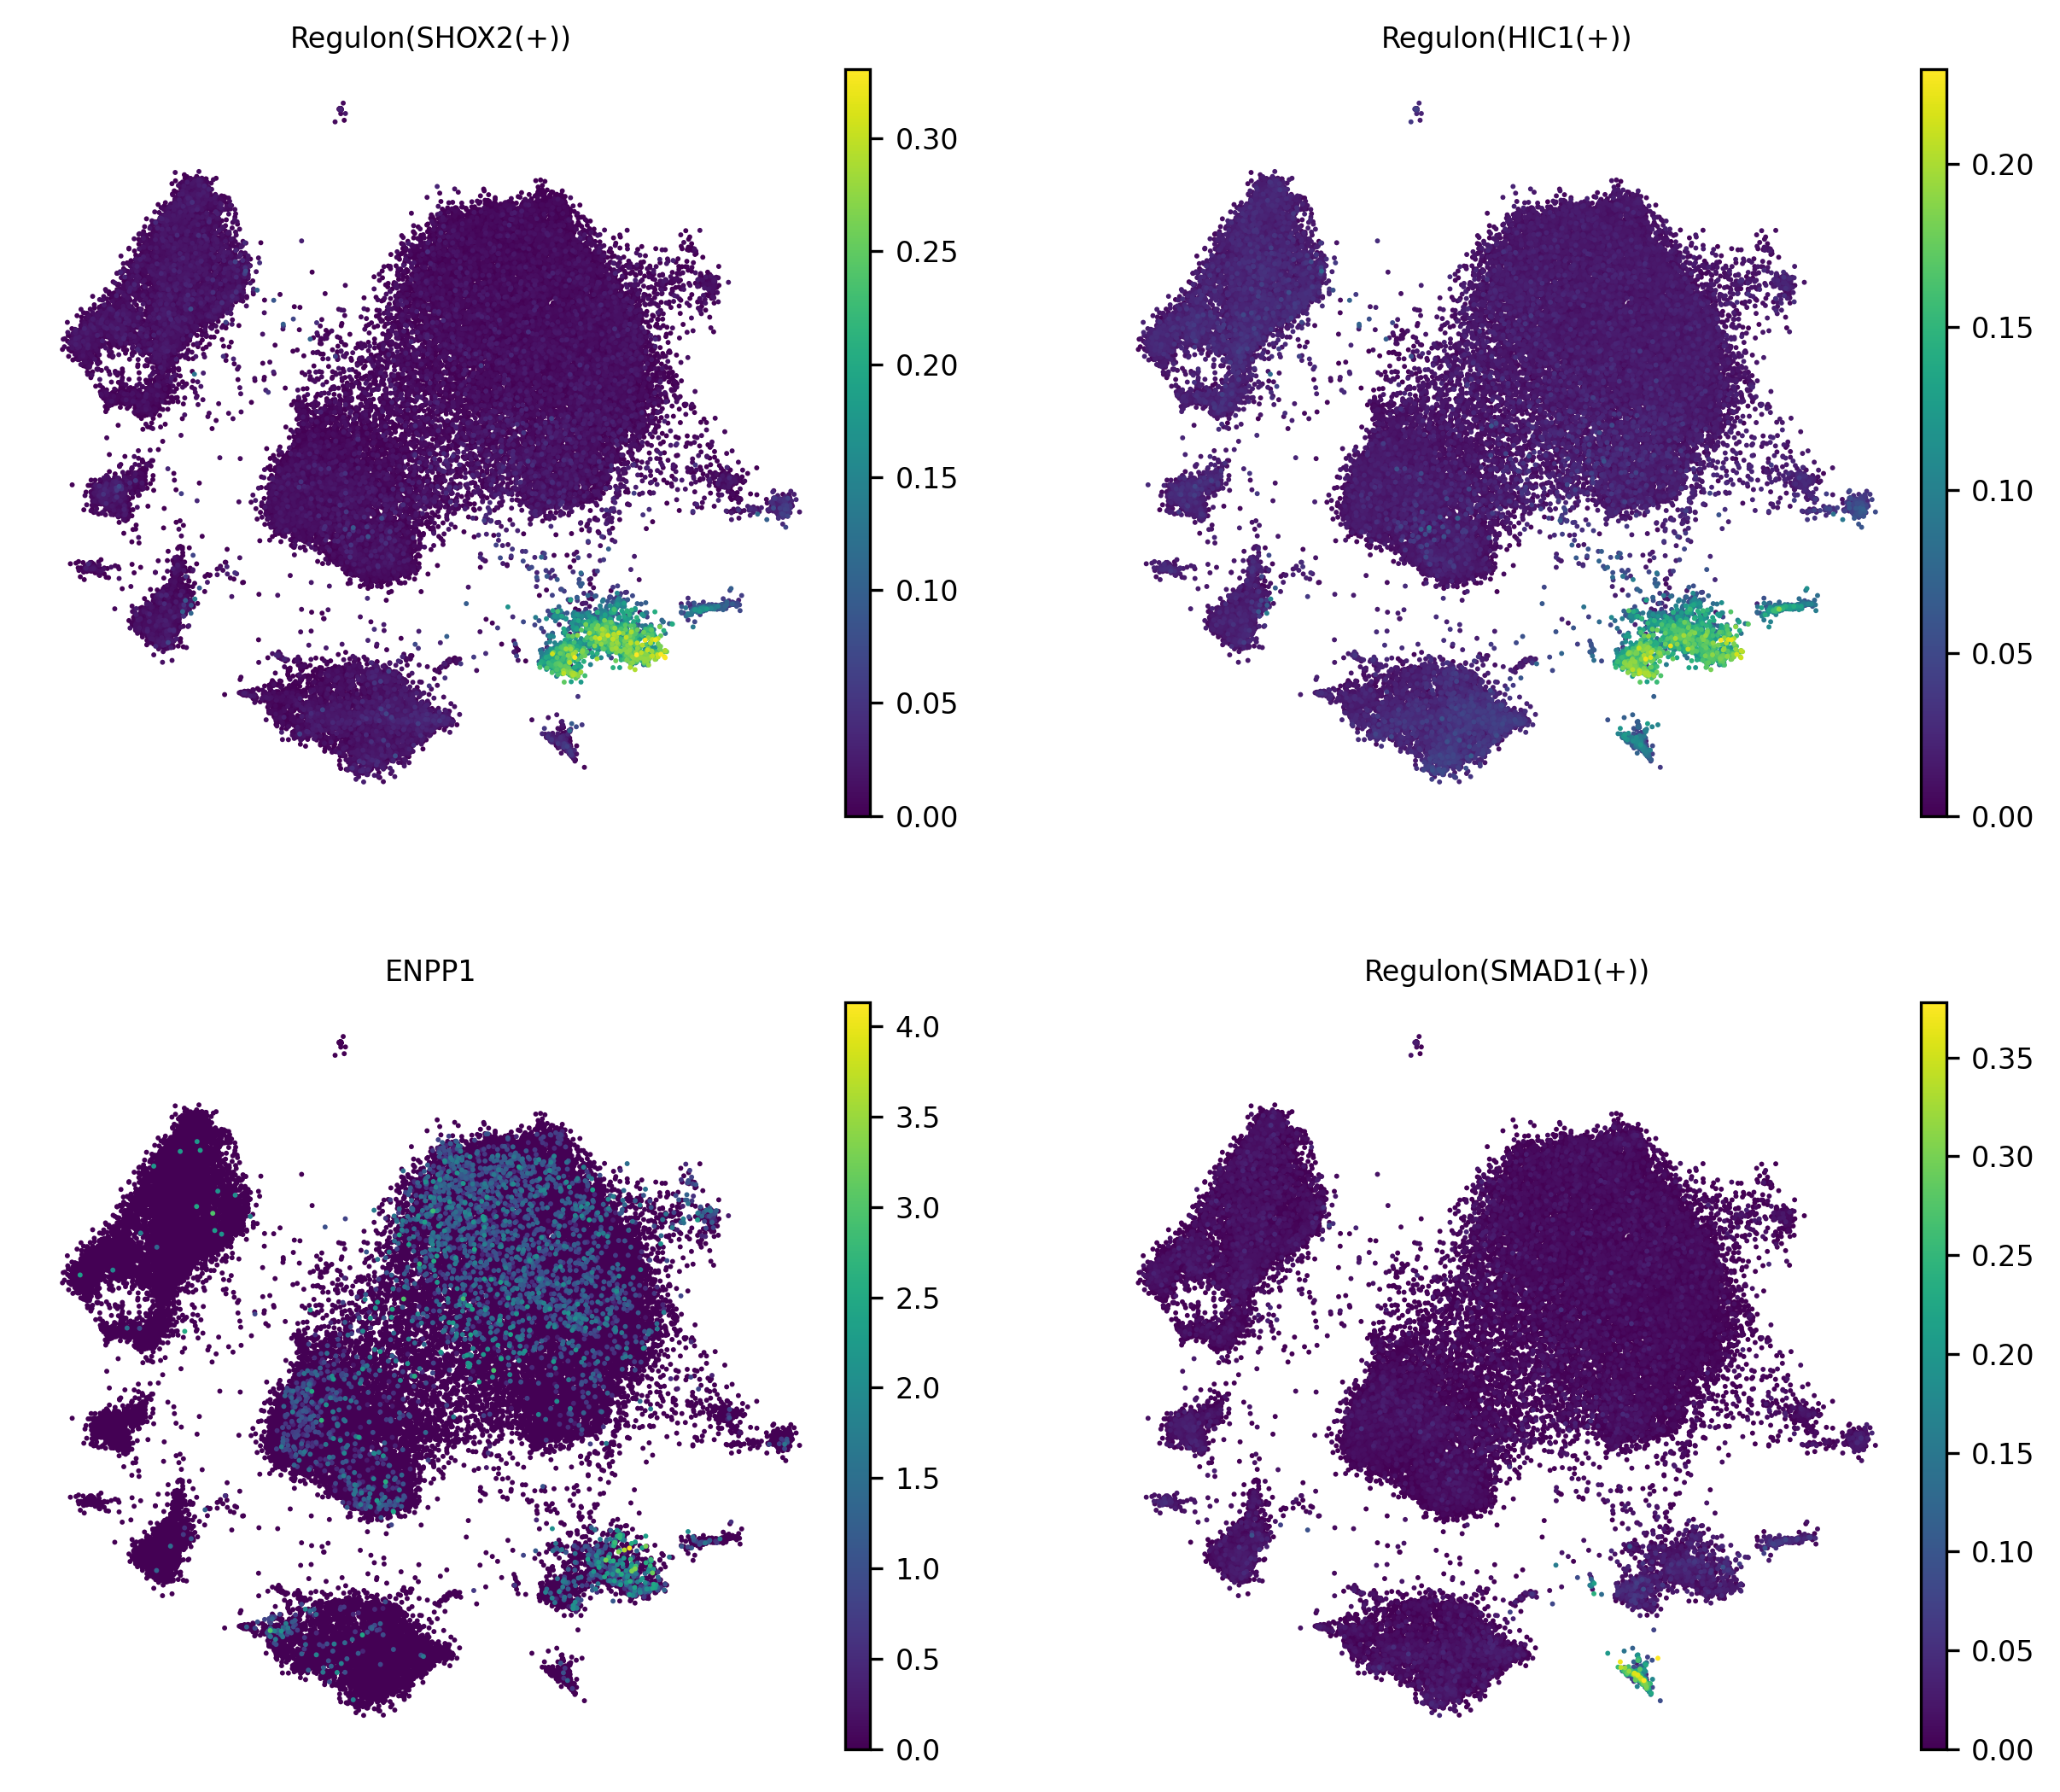

In [29]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.embedding(
    adatas['TNBC'],
    basis="X_scanvi_MDE",
    color=["Regulon(SHOX2(+))", "Regulon(HIC1(+))", "ENPP1","Regulon(SMAD1(+))"],
    frameon=False,
    ncols=2,use_raw = False, cmap = "viridis", size = 8)

In [ ]:
sc.pl.dotplot(adatas['ER'], ['Regulon(MITF(+))', 'Regulon(MYC(+))', 'Regulon(DDIT3(+))',], groupby='cell_type')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_heatmap = pd.pivot_table(data=df_results[df_results.Z >= 3.0].sort_values('Z', ascending=False),
                           index='cell_type', columns='regulon', values='Z')
#df_heatmap.drop(index='Myocyte', inplace=True) # We leave out Myocyte because many TFs are highly enriched (becuase of small number of cells).
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(df_heatmap, ax=ax1, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 6})
ax1.set_ylabel('')

In [ ]:
from pyscenic.rss import regulon_specificity_scores

In [ ]:
rss_dict = {}

for key in adatas.keys():
    rss = regulon_specificity_scores(aucells[key], adatas[key].obs.cell_type)
    rss_dict[key] = rss

In [ ]:
rss_dict['TNBC']

In [ ]:
adata.obs['cell_type'].cat.categories

In [ ]:
from pyscenic.plotting import plot_binarization, plot_rss

In [ ]:
for rss in rss_dict.values():
    
    sns.set()
    sns.set(style='whitegrid', font_scale=0.8)
    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(8, 6), dpi=100)
    plot_rss(rss, 'B Cells', ax=ax1)
    ax1.set_xlabel('')
    plot_rss(rss, 'TCells', ax=ax2)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    plot_rss(rss, 'Fibroblasts', ax=ax3)
    ax3.set_xlabel('')
    ax3.set_ylabel('')
    plot_rss(rss, 'Epithelial', ax=ax4)
    ax4.set_xlabel('')
    ax4.set_ylabel('')
    plot_rss(rss, 'PlasmaCells', ax=ax5)
    plot_rss(rss, 'CyclingEpithelial', ax=ax6)
    ax6.set_ylabel('')
    plot_rss(rss, 'MastCells', ax=ax7)
    ax7.set_ylabel('')
    plot_rss(rss, 'Endothelial', ax=ax8)
    ax8.set_ylabel('')
    plt.tight_layout()

In [ ]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.embedding(
    adatas['ER'],
    basis="X_scanvi_MDE",
    color=["Regulon(POU2F2(+))","cell_type", "Regulon(E2F2(+))", "ENPP1"],
    frameon=False,
    ncols=2,use_raw = False, cmap = "viridis", size = 8)



In [ ]:
sc.pl.embedding(
    adatas['TNBC'],
    basis="X_scanvi_MDE",
    color=["Regulon(POU2F2(+))","cell_type", "Regulon(E2F2(+))", "ENPP1"],
    frameon=False,
    ncols=2,use_raw = False, cmap = "viridis", size = 8)

In [ ]:
modules['TNBC']

In [ ]:
modules['TNBC'][modules['TNBC'].target == "ENPP1"].sort_values('importance', ascending = False).TF.to_list()

In [ ]:
sc.pl.embedding(
    adatas['TNBC'],
    basis="X_scanvi_MDE",
    color=["cell_type", "ENPP1", "Regulon(GATA3(+))","Regulon(XBP1(+))","Regulon(ESR1(+))","Regulon(ZNF385D(+))", "Regulon(AR(+))"],
    frameon=False,
    ncols=3,use_raw = False, cmap = "viridis", size = 8)

In [ ]:
some_gene = "ENPP1"

matching_regulons = [
    r
    for r in regulons["TNBC"]
    if some_gene in r.gene2weight and isinstance(r.gene2weight[some_gene], float)
]

In [ ]:
matching_regulons

In [ ]:
some_tf = "AEBP1"
match = next((r for r in regulons['TNBC'] if r.name == some_tf), None)

if match is not None:
    print(f"Regulon found for TF '{some_tf}': {match.name}")
else:
    print(f"No regulon found for TF '{some_tf}'")

In [ ]:
match.name

In [ ]:
[regulons['TNBC'][1].name == "TRPS1"]

In [ ]:
sc.pl.embedding(
    adatas['TNBC'],
    basis="X_scanvi_MDE",
    color=["cell_type", "ENPP1", "Regulon(GATA3(+))","Regulon(XBP1(+))","Regulon(ESR1(+))","Regulon(ZNF385D(+))", "Regulon(AR(+))"],
    frameon=False,
    ncols=3,use_raw = False, cmap = "viridis", size = 8)

In [57]:
pd.DataFrame({"barcode_sample" : adatas['TNBC'].obs_names.values,
             "cell_type" : adatas['TNBC'].obs.cell_type.values}).to_csv("/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/cpdb/metadata.tsv", sep = '\t', index = False)